<a href="https://colab.research.google.com/github/mrp-78/implement-KNN/blob/main/implement_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [1]:
import csv
import pandas as pd

cols = []
data = []
dataStarted = False
for line in open('./drive/My Drive/Colab Notebooks/adult.dat', 'r'):
  line = line.rstrip().split()
  if line[0] == '@relation': 
    pass
  elif line[0] == '@attribute':
    cols.append(line[1])
  elif line[0] == '@data':
    dataStarted = True
  elif dataStarted:
    row = line[0]
    data.append(row.split(','))

In [2]:
df = pd.DataFrame(data, columns=cols)
for col in cols:
  if df[col][0].isdigit():
    df[col] = pd.to_numeric(df[col]) 
df

,Age,Workclass,Fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


# Preprocessing

## handle missing values

In [4]:
null_cols = []
null_count = []
null_percen = []
for i in df.columns:
    val = len(df[df[i] == "?"])
    if  val > 0:
        null_cols.append(i)
        null_count.append(val)
        null_percen.append(val/len(df)*100)
null_dic = {"columns" : null_cols, "count" : null_count, "percentage" : null_percen}
null_df = pd.DataFrame.from_dict(null_dic)
null_df 

,columns,count,percentage
0,Workclass,2799,5.730724
1,Occupation,2809,5.751198
2,Native-country,857,1.754637


In [5]:
# data imputation for ? values => replace ? with mode value
for col in null_cols:
  df[col] = df[col].replace("?", df[col].mode()[0])

null_cols = []
null_count = []
null_percen = []
for i in df.columns:
    val = len(df[df[i] == "?"])
    if  val > 0:
        null_cols.append(i)
        null_count.append(val)
        null_percen.append(val/len(df)*100)
null_dic = {"columns" : null_cols, "count" : null_count, "percentage" : null_percen}
null_df = pd.DataFrame.from_dict(null_dic)
null_df 

,columns,count,percentage


## bining age column

In [6]:
df['Age'] = pd.cut(df.Age,bins=[16,25,40,65,95],labels=[0,1,2,3])
df['Age'] = pd.to_numeric(df['Age'])
df.Age

0        0
1        1
2        1
3        2
4        0
        ..
48837    1
48838    1
48839    2
48840    0
48841    2
Name: Age, Length: 48842, dtype: int64

## split data and target column

In [7]:
y = df['Class']
x = df.drop(['Class'], axis=1)

## handle categorical columns

In [8]:
numerical_cols = x._get_numeric_data().columns
categorical_cols = list(set(x.columns) - set(numerical_cols))
categorical_cols

['Race',
 'Relationship',
 'Education',
 'Marital-status',
 'Sex',
 'Occupation',
 'Native-country',
 'Workclass']

### one hot label encoding

In [9]:
x = pd.concat([x, pd.get_dummies(x[categorical_cols])], axis=1)
x = x.drop(categorical_cols,axis=1)
x

,Age,Fnlwgt,Education-num,Capital-gain,Capital-loss,Hours-per-week,Race_Amer-Indian-Eskimo,Race_Asian-Pac-Islander,Race_Black,Race_Other,Race_White,Relationship_Husband,Relationship_Not-in-family,Relationship_Other-relative,Relationship_Own-child,Relationship_Unmarried,Relationship_Wife,Education_10th,Education_11th,Education_12th,Education_1st-4th,Education_5th-6th,Education_7th-8th,Education_9th,Education_Assoc-acdm,Education_Assoc-voc,Education_Bachelors,Education_Doctorate,Education_HS-grad,Education_Masters,Education_Preschool,Education_Prof-school,Education_Some-college,Marital-status_Divorced,Marital-status_Married-AF-spouse,Marital-status_Married-civ-spouse,Marital-status_Married-spouse-absent,Marital-status_Never-married,Marital-status_Separated,Marital-status_Widowed,...,Native-country_France,Native-country_Germany,Native-country_Greece,Native-country_Guatemala,Native-country_Haiti,Native-country_Holand-Netherlands,Native-country_Honduras,Native-country_Hong,Native-country_Hungary,Native-country_India,Native-country_Iran,Native-country_Ireland,Native-country_Italy,Native-country_Jamaica,Native-country_Japan,Native-country_Laos,Native-country_Mexico,Native-country_Nicaragua,Native-country_Outlying-US(Guam-USVI-etc),Native-country_Peru,Native-country_Philippines,Native-country_Poland,Native-country_Portugal,Native-country_Puerto-Rico,Native-country_Scotland,Native-country_South,Native-country_Taiwan,Native-country_Thailand,Native-country_Trinadad&Tobago,Native-country_United-States,Native-country_Vietnam,Native-country_Yugoslavia,Workclass_Federal-gov,Workclass_Local-gov,Workclass_Never-worked,Workclass_Private,Workclass_Self-emp-inc,Workclass_Self-emp-not-inc,Workclass_State-gov,Workclass_Without-pay
0,0,226802,7,0,0,40,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1,1,89814,9,0,0,50,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2,1,336951,12,0,0,40,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
3,2,160323,10,7688,0,40,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
4,0,103497,10,0,0,30,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,1,257302,12,0,0,38,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
48838,1,154374,9,0,0,40,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
48839,2,151910,9,0,0,40,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
48840,0,201490,9,0,0,20,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


## normalize data

In [11]:
for col in numerical_cols:
  if col != 'Age':
    x[col]=(x[col] - x[col].min()) / (x[col].max() - x[col].min())
x

,Age,Fnlwgt,Education-num,Capital-gain,Capital-loss,Hours-per-week,Race_Amer-Indian-Eskimo,Race_Asian-Pac-Islander,Race_Black,Race_Other,Race_White,Relationship_Husband,Relationship_Not-in-family,Relationship_Other-relative,Relationship_Own-child,Relationship_Unmarried,Relationship_Wife,Education_10th,Education_11th,Education_12th,Education_1st-4th,Education_5th-6th,Education_7th-8th,Education_9th,Education_Assoc-acdm,Education_Assoc-voc,Education_Bachelors,Education_Doctorate,Education_HS-grad,Education_Masters,Education_Preschool,Education_Prof-school,Education_Some-college,Marital-status_Divorced,Marital-status_Married-AF-spouse,Marital-status_Married-civ-spouse,Marital-status_Married-spouse-absent,Marital-status_Never-married,Marital-status_Separated,Marital-status_Widowed,...,Native-country_France,Native-country_Germany,Native-country_Greece,Native-country_Guatemala,Native-country_Haiti,Native-country_Holand-Netherlands,Native-country_Honduras,Native-country_Hong,Native-country_Hungary,Native-country_India,Native-country_Iran,Native-country_Ireland,Native-country_Italy,Native-country_Jamaica,Native-country_Japan,Native-country_Laos,Native-country_Mexico,Native-country_Nicaragua,Native-country_Outlying-US(Guam-USVI-etc),Native-country_Peru,Native-country_Philippines,Native-country_Poland,Native-country_Portugal,Native-country_Puerto-Rico,Native-country_Scotland,Native-country_South,Native-country_Taiwan,Native-country_Thailand,Native-country_Trinadad&Tobago,Native-country_United-States,Native-country_Vietnam,Native-country_Yugoslavia,Workclass_Federal-gov,Workclass_Local-gov,Workclass_Never-worked,Workclass_Private,Workclass_Self-emp-inc,Workclass_Self-emp-not-inc,Workclass_State-gov,Workclass_Without-pay
0,0,0.145129,0.400000,0.000000,0.0,0.397959,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1,1,0.052451,0.533333,0.000000,0.0,0.500000,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2,1,0.219649,0.733333,0.000000,0.0,0.397959,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
3,2,0.100153,0.600000,0.076881,0.0,0.397959,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
4,0,0.061708,0.600000,0.000000,0.0,0.295918,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,1,0.165763,0.733333,0.000000,0.0,0.377551,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
48838,1,0.096129,0.533333,0.000000,0.0,0.397959,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
48839,2,0.094462,0.533333,0.000000,0.0,0.397959,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
48840,0,0.128004,0.533333,0.000000,0.0,0.193878,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


## convert data to numpy array

In [12]:
x = x.to_numpy()
x

array([[0.        , 0.14512876, 0.4       , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.05245126, 0.53333333, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.21964867, 0.73333333, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [2.        , 0.09446153, 0.53333333, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.12800425, 0.53333333, ..., 0.        , 0.        ,
        0.        ],
       [2.        , 0.18648211, 0.53333333, ..., 0.        , 0.        ,
        0.        ]])

## map target classes to 0 and 1
0: <=50k

1: >50k

In [13]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y.unique())
y = le.transform(y)
y

array([0, 0, 1, ..., 0, 0, 1])

## train/test split

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.20)

# Train and Test Data

## Implement KNN from scratch
in below sell I implement KNN algorithm with 2 version:



*   **Vectorized:** in this version distance of two vector calculated by using numpy linalg norm function
*   **Non-Vectorized:** in this version distance of two vector calculted by looping over all vector elements



In [16]:
from math import sqrt
from numpy import linalg

def distance(data1, data2):
  dist = 0
  for i in range(len(data1)):
    dist += (data1[i] - data2[i])**2
  return sqrt(dist)

def find_label(train_x, train_y, data, k, vectorized=False):
  neighbors = []
  for i in range(len(train_x)):
    if vectorized:
      dist = linalg.norm(train_x[i]-data) # use row vectors and numpy 
    else:
      dist = distance(train_x[i], data) # use for loop to calculate distance
    if len(neighbors) >= k:
      if neighbors[k-1][0] > dist:
        neighbors.append((dist, train_y[i]))
        neighbors.sort(key=lambda tup: tup[0])
        del neighbors[-1]
    else:
      neighbors.append((dist, train_y[i]))
      neighbors.sort(key=lambda tup: tup[0])
  output_values = [row[-1] for row in neighbors]
  prediction = max(set(output_values), key=output_values.count)
  return prediction

def KNN(train_x, train_y, test, k=15, vectorized=False):
  predicts = []
  for i in range(len(test)):
    pred = find_label(train_x, train_y, test[i], k, vectorized)
    predicts.append(pred)
  return predicts

### compare predictin time of Vectorized and Non-Vectorized versions by predict on 10 test examples



In [17]:
import time
print("# compare train on 10 test example\n")
print("train without any vectorization")
start_time = time.time()
y_pred = KNN(X_train, y_train, X_test[:10])
print("--- %s seconds ---" % (time.time() - start_time))

print("\nuse vectorization for each row of train data and test data")
start_time = time.time()
y_pred = KNN(X_train, y_train, X_test[:10], vectorized=True)
print("--- %s seconds ---" % (time.time() - start_time))

# compare train on 10 test example

train without any vectorization
--- 38.06770467758179 seconds ---

use vectorization for each row of train data and test data
--- 2.946079730987549 seconds ---


## Implement Full-Vectorized KNN
in the below sell I calculate distances matrix directly from train matrix and loop over train samples deleted

In [18]:
from math import sqrt
from numpy import linalg

def find_label_fast(train_x, train_y, data, k):
  neighbors = []
  data = data.reshape((1, len(data)))
  dist = linalg.norm(train_x-data, axis=1) # calculate distance using train matrix and numpy
  neighbors = list(zip(dist, train_y))
  neighbors.sort(key=lambda tup: tup[0])
  neighbors = neighbors[:k]
  output_values = [row[-1] for row in neighbors]
  prediction = max(set(output_values), key=output_values.count)
  return prediction

def KNN_fast(train_x, train_y, test, k=21):
  predicts = []
  for i in range(len(test)):
    pred = find_label_fast(train_x, train_y, test[i], k)
    predicts.append(pred)
  return predicts

### compare predictin time of Vectorized and Full-Vectorized versions by predict on 100 test examples

In [21]:
import time

print("# compare train on 100 test example\n")
print("use Vectorized version")
start_time = time.time()
y_pred = KNN(X_train, y_train, X_test[:100], vectorized=True)
print("--- %s seconds ---" % (time.time() - start_time))

print("\nuse Full-Vectorized version")
start_time = time.time()
y_pred = KNN_fast(X_train, y_train, X_test[:100], k=15)
print("--- %s seconds ---" % (time.time() - start_time))
# y_pred

# compare train on 100 test example

use Vectorized version
--- 29.69001531600952 seconds ---

use Full-Vectorized version
--- 6.18212628364563 seconds ---


## Train and Predict on test data

In [22]:
from sklearn.metrics import accuracy_score

y_pred = KNN_fast(X_train, y_train, X_test)
print('accuracy: ', accuracy_score(y_test, y_pred))

accuracy:  0.8357047804278841


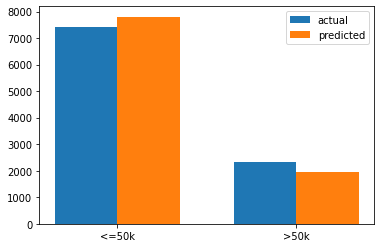

In [23]:
import matplotlib.pyplot as plt
import numpy as np

N = 2
actual = [np.count_nonzero(y_test == 0), np.count_nonzero(y_test)]
predict = [len(y_pred) - np.count_nonzero(y_pred), np.count_nonzero(y_pred)]

ind = np.arange(N) 
width = 0.35       
plt.bar(ind, actual, width, label='actual')
plt.bar(ind + width, predict, width,
    label='predicted')

plt.xticks(ind + width / 2, ('<=50k', '>50k'))
plt.legend(loc='best')
plt.show()